<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Including-degrees-of-cooperativness-and-selfishsness" data-toc-modified-id="Including-degrees-of-cooperativness-and-selfishsness-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Including degrees of cooperativness and selfishsness</a></span></li><li><span><a href="#Including-degrees-of-cooperativness-and-selfishsness-with-mutations" data-toc-modified-id="Including-degrees-of-cooperativness-and-selfishsness-with-mutations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Including degrees of cooperativness and selfishsness with mutations</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import math
import random
import itertools
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns


def create_pool(size):
    '''
    Creating an initial population containing 4 different types of
    individuals:

    0 -> Selfish
    1 -> Quite Selfish
    2 -> Quite Cooperative
    3 -> Cooperative
    '''
    res = np.repeat(['0L', '0S', '1L', '1S', '2L', '2S', '3L', '3S'], size/4)
    random.shuffle(res)
    return res


def divide_in_groups(pool, large_g=40, small_g=4):
    '''
    Dividing the current population into two main divisions: one containing
    all the different types of large individuals and one containing instead
    all the types of small individuals. These two divisions are additionally
    splitted in multiple groups depending on the large_g and small_g parameters
    which represent respectively the fixed group size that each large and small
    group should have. If there are not enough individuals left to fill a group
    they are automatically discarded.
    '''
    large = [ind for ind in pool if ind[1] == 'L']
    small = [ind for ind in pool if ind[1] == 'S']
    discard_large = int(large_g*(len(large)/large_g - math.floor(len(large)/large_g)))
    discard_small = int(small_g*(len(small)/small_g - math.floor(len(small)/small_g)))
    try:
        groups_l = np.array(large[: len(large) - discard_large])
        groups_l = groups_l.reshape(math.floor(len(large)/large_g), -1)
    except:
        if groups_l.size == 0:
            groups_s = np.array(small[: len(small) - discard_small])
            groups_s = groups_s.reshape(math.floor(len(small)/small_g), -1)
            return groups_l, groups_s
        groups_l = np.array(large[: len(large) - discard_large - 1])
        groups_l = groups_l.reshape(math.floor(len(large)/large_g), -1)
    try:
        groups_s = np.array(small[: len(small) - discard_small])
        groups_s = groups_s.reshape(math.floor(len(small)/small_g), -1)
    except:
        if groups_s.size == 0:
            return groups_l, groups_s
        groups_s = np.array(small[: len(small) - discard_small -1])
        groups_s = groups_s.reshape(math.floor(len(small)/small_g), -1)
    return groups_l, groups_s


def reproduction(large_gs, small_gs, disposal_limit=4, large_r=50, small_r=4, self_g=0.02, coop_g=0.018, self_c=0.2,
                 coop_c=0.1, K=0.1):
    '''
    Reproduction takes place just within divisions and they are dependent
    on the magnitude of the share of the total group resource that the
    genotype receives and the replicator equations (shown above).
    Therefore, the reproduction results are highly dependent of the disposal
    time and the equations parameters.
    '''
    i = 0
    large_g_res = [[]] * len(large_gs)
    small_g_res = [[]] * len(small_gs)
    #print(len(large_gs), len(small_gs))
    for large_g, small_g in itertools.zip_longest(large_gs, small_gs):
        if large_g is None and small_g is not None:
            unique, counts = np.unique(small_g, return_counts=True)
            small_counts = dict(zip(unique, counts))
            disp_time = 0
            small_1 = small_counts.get('0S', 0)
            small_2 = small_counts.get('1S', 0)
            small_3 = small_counts.get('2S', 0)
            small_4 = small_counts.get('3S', 0)
            dem = (small_1 * self_g * self_c + small_2 * ((self_g/1.2) * (self_c/1.2)) + small_3 * ((self_g/1.4) * (self_c/1.4)) + small_4 * coop_g * coop_c)
            while disp_time != disposal_limit:
                small_1_R_i = (small_1 * self_g * self_c) / dem * small_r
                small_2_R_i = (small_2 * ((self_g/1.2) * (self_c/1.2))) / dem * small_r
                small_3_R_i = (small_3 * ((self_g/1.4) * (self_c/1.4))) / dem * small_r
                small_4_R_i = (small_4 * coop_g * coop_c) / dem * small_r
                small_1 = small_1 + small_1_R_i / self_c - K * small_1 
                small_2 = small_2 + (small_2_R_i / (self_c/1.2)) - K * small_2
                small_3 = small_3 + (small_3_R_i / (self_c/1.4)) - K * small_3
                small_4 = small_4 + small_4_R_i / coop_c - K * small_4
                disp_time += 1

            small_g_res[i] = []
            small_g_res[i].extend(['0S'] * int(small_1))
            small_g_res[i].extend(['1S'] * int(small_2))
            small_g_res[i].extend(['2S'] * int(small_3))
            small_g_res[i].extend(['3S'] * int(small_4))
            i += 1
        elif small_g is None and large_g is not None:
            disp_time = 0
            unique, counts = np.unique(large_g, return_counts=True)
            large_counts = dict(zip(unique, counts))
            large_1 = large_counts.get('0L', 0)
            large_2 = large_counts.get('1L', 0)
            large_3 = large_counts.get('2L', 0)
            large_4 = large_counts.get('3L', 0)
            dem2 = (large_1 * self_g * self_c + large_2 * ((self_g/1.2) * (self_c/1.2)) + large_3 * ((self_g/1.4) * (self_c/1.4)) + large_4 * coop_g * coop_c)
            while disp_time != disposal_limit:
                large_1_R_i = (large_1 * self_g * self_c) / dem2 * large_r
                large_2_R_i = (large_2 * ((self_g/1.2) * (self_c/1.2))) / dem2 * large_r
                large_3_R_i = (large_3 * ((self_g/1.4) * (self_c/1.4))) / dem2 * large_r
                large_4_R_i = (large_4 * coop_g * coop_c) / dem2 * large_r
                large_1 = large_1 + large_1_R_i / self_c - K * large_1 
                large_2 = large_2 + (large_2_R_i / (self_c/1.2)) - K * large_2
                large_3 = large_3 + (large_3_R_i / (self_c/1.4)) - K * large_3
                large_4 = large_4 + large_4_R_i / self_c - K * large_4
                disp_time += 1

            large_g_res[i] = []
            large_g_res[i].extend(['0L'] * int(large_1))
            large_g_res[i].extend(['1L'] * int(large_2))
            large_g_res[i].extend(['2L'] * int(large_3))
            large_g_res[i].extend(['3L'] * int(large_4))
            i += 1
        else:
            unique, counts = np.unique(small_g, return_counts=True)
            small_counts = dict(zip(unique, counts))
            disp_time = 0
            small_1 = small_counts.get('0S', 0)
            small_2 = small_counts.get('1S', 0)
            small_3 = small_counts.get('2S', 0)
            small_4 = small_counts.get('3S', 0)
            dem = (small_1 * self_g * self_c + small_2 * ((self_g/1.2) * (self_c/1.2)) + small_3 * ((self_g/1.4) * (self_c/1.4)) + small_4 * coop_g * coop_c)
            unique, counts = np.unique(large_g, return_counts=True)
            large_counts = dict(zip(unique, counts))
            large_1 = large_counts.get('0L', 0)
            large_2 = large_counts.get('1L', 0)
            large_3 = large_counts.get('2L', 0)
            large_4 = large_counts.get('3L', 0)
            dem2 = (large_1 * self_g * self_c + large_2 * ((self_g/1.2) * (self_c/1.2)) + large_3 * ((self_g/1.4) * (self_c/1.4)) + large_4 * coop_g * coop_c)
            while disp_time != disposal_limit:
                large_1_R_i = (large_1 * self_g * self_c) / dem2 * large_r
                large_2_R_i = (large_2 * ((self_g/1.2) * (self_c/1.2))) / dem2 * large_r
                large_3_R_i = (large_3 * ((self_g/1.4) * (self_c/1.4))) / dem2 * large_r
                large_4_R_i = (large_4 * coop_g * coop_c) / dem2 * large_r
                large_1 = large_1 + large_1_R_i / self_c - K * large_1 
                large_2 = large_2 + (large_2_R_i / (self_c/1.2)) - K * large_2
                large_3 = large_3 + (large_3_R_i / (self_c/1.4)) - K * large_3
                large_4 = large_4 + large_4_R_i / self_c - K * large_4
                small_1_R_i = (small_1 * self_g * self_c) / dem * small_r
                small_2_R_i = (small_2 * ((self_g/1.2) * (self_c/1.2))) / dem * small_r
                small_3_R_i = (small_3 * ((self_g/1.4) * (self_c/1.4))) / dem * small_r
                small_4_R_i = (small_4 * coop_g * coop_c) / dem * small_r
                small_1 = small_1 + small_1_R_i / self_c - K * small_1
                small_2 = small_2 + (small_2_R_i / (self_c/1.2)) - K * small_2
                small_3 = small_3 + (small_3_R_i / (self_c/1.4)) - K * small_3
                small_4 = small_4 + small_4_R_i / coop_c - K * small_4
                disp_time += 1

            large_g_res[i] = []
            large_g_res[i].extend(['0L'] * int(large_1))
            large_g_res[i].extend(['1L'] * int(large_2))
            large_g_res[i].extend(['2L'] * int(large_3))
            large_g_res[i].extend(['3L'] * int(large_4))
            small_g_res[i] = []
            small_g_res[i].extend(['0S'] * int(small_1))
            small_g_res[i].extend(['1S'] * int(small_2))
            small_g_res[i].extend(['2S'] * int(small_3))
            small_g_res[i].extend(['3S'] * int(small_4))
            i += 1

    return large_g_res, small_g_res


def update_pool(large_gs, small_gs, mutation=False):
    '''
    In this case, are taken as input the two divisions which had undergone
    reproduction and are merged together to create a pool like the one created
    in the initialization step. In this situation, we need to make sure that
    overall population size remains the same.
    '''
    res = reduce(lambda x,y :x+y ,large_gs, []) + reduce(lambda x,y :x+y , small_gs, [])
    unique, counts = np.unique(res, return_counts=True)
    pop_counts = dict(zip(unique, counts))
    new_pop_elements = [int(((i/len(res))*pop)) for i in pop_counts.values()]
    res = np.repeat([*pop_counts.keys()], new_pop_elements).tolist()
    random.shuffle(res)
    if mutation is True:
        for i in range(0, int(len(res)/2)):
            res[i] = (np.random.choice(['0' + res[i][1], '1' + res[i][1], '2' + res[i][1], '3' + res[i][1]], 
                            p=[1/4, 1/4, 1/4, 1/4]))
    return res


def stats(df):
    '''
    Statistical analysis summary of the experiment
    (eg. Mean and Std of each column, box plot showing
    data distribution of each column and correlation matrix of the dataframe)
    '''
    for i in range(1, len(df.columns)):
        print(df.columns.values[i])
        print('Mean: ', np.mean(df.iloc[:, i]), 'Std: ', np.std(df.iloc[:, i]))

    df.iloc[:, 1:].plot.box(rot=0, fontsize=16, figsize=(11, 8), grid=True)
    plt.show()

    sns.heatmap(df.corr(), annot=True)

## Including degrees of cooperativness and selfishsness

In [2]:
pop = 4000
iter_num = 20
d = {'Iteration Num': [0], '0Large': [500], '1Large': [500],
     '2Large': [500], '3Large': [500], '0Small': [500], 
     '1Small': [500], '2Small': [500], '3Small': [500]}
df = pd.DataFrame(data=d)
migrant_pool = create_pool(pop)
for i in range(1, iter_num + 1):
    large_group, small_group = divide_in_groups(migrant_pool)
    large_group, small_group = reproduction(large_group, small_group)
    migrant_pool = update_pool(large_group, small_group)
    unique, counts = np.unique(migrant_pool, return_counts=True)
    res_counts = dict(zip(unique, counts))
    df = df.append({"Iteration Num": i,
                    "0Large": res_counts.get('0L', 0),
                    "1Large": res_counts.get('1L', 0),
                    "2Large": res_counts.get('2L', 0),
                    "3Large": res_counts.get('3L', 0),
                    "0Small": res_counts.get('0S', 0),
                    "1Small": res_counts.get('1S', 0),
                    "2Small": res_counts.get('2S', 0),
                    "3Small": res_counts.get('3S', 0),
                    }, ignore_index=True)
    if i % 5 == 0:
        print('Iteration Number:', i)

Iteration Number: 5
Iteration Number: 10
Iteration Number: 15
Iteration Number: 20


In [3]:
df.head(20)

,Iteration Num,0Large,1Large,2Large,3Large,0Small,1Small,2Small,3Small
0,0,500,500,500,500,500,500,500,500
1,1,1235,669,390,81,415,339,254,613
2,2,1621,471,163,7,416,253,150,916
3,3,1440,228,48,0,438,207,105,1531
4,4,832,72,8,0,428,156,61,2439
5,5,303,14,0,0,335,100,31,3213
6,6,72,1,0,0,211,54,13,3647
7,7,8,0,0,0,128,28,5,3829
8,8,0,0,0,0,73,13,2,3910
9,9,0,0,0,0,42,6,0,3950


0Large
Mean:  286.23809523809524 Std:  513.8635083516044
1Large
Mean:  93.0952380952381 Std:  194.5404609064789
2Large
Mean:  52.80952380952381 Std:  133.17929878018862
3Large
Mean:  28.0 Std:  106.93700860564508
0Small
Mean:  144.33333333333334 Std:  184.3620489129069
1Small
Mean:  78.95238095238095 Std:  134.36286199991144
2Small
Mean:  53.38095238095238 Std:  118.1365135242462
3Small
Mean:  3261.5714285714284 Std:  1216.934265604647


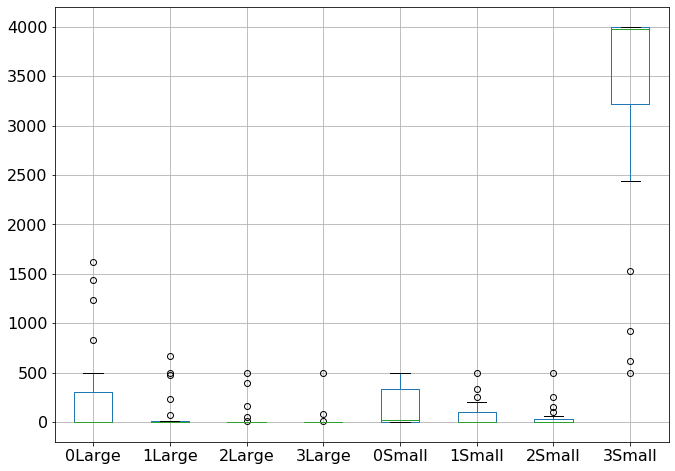

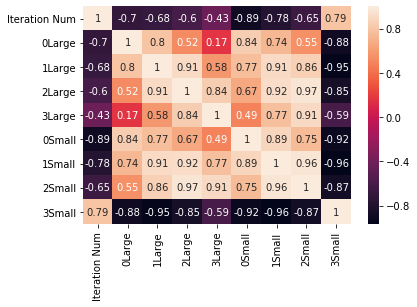

In [4]:
stats(df)

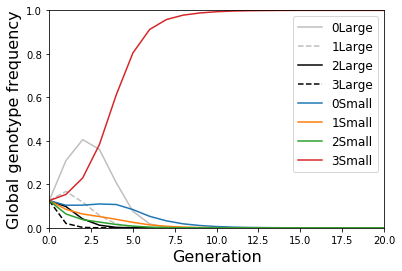

In [5]:
tot = (df['0Large'] + df['1Large'] + df['2Large'] + df['3Large'] + df['0Small']+ df['1Small'] + df['2Small'] + df['3Small'])
plt.plot(df['Iteration Num'], df['0Large']/tot, '0.75', label = '0Large')
plt.plot(df['Iteration Num'], df['1Large']/tot, '--', color= '0.75', label = '1Large')
plt.plot(df['Iteration Num'], df['2Large']/tot, 'k', label = '2Large')
plt.plot(df['Iteration Num'], df['3Large']/tot, 'k--', label = '3Large')
plt.plot(df['Iteration Num'], df['0Small']/tot, label = '0Small')
plt.plot(df['Iteration Num'], df['1Small']/tot, label = '1Small')
plt.plot(df['Iteration Num'], df['2Small']/tot, label = '2Small')
plt.plot(df['Iteration Num'], df['3Small']/tot, label = '3Small')
plt.xlim(0, 20)
plt.ylim(0, 1)
plt.xlabel("Generation", fontsize=16)
plt.ylabel("Global genotype frequency", fontsize=16)
plt.legend(fontsize=12)

## Including degrees of cooperativness and selfishsness with mutations

In [6]:
# pop = 4000
# iter_num = 120
# d = {'Iteration Num': [0], '0Large': [500], '1Large': [500],
#      '2Large': [500], '3Large': [500], '0Small': [500], 
#      '1Small': [500], '2Small': [500], '3Small': [500]}
# df = pd.DataFrame(data=d)
# migrant_pool = create_pool(pop)
# for i in range(1, iter_num + 1):
#     large_group, small_group = divide_in_groups(migrant_pool)
#     large_group, small_group = reproduction(large_group, small_group)
#     migrant_pool = update_pool(large_group, small_group, mutation=True)
#     unique, counts = np.unique(migrant_pool, return_counts=True)
#     res_counts = dict(zip(unique, counts))
#     df = df.append({"Iteration Num": i,
#                     "0Large": res_counts.get('0L', 0),
#                     "1Large": res_counts.get('1L', 0),
#                     "2Large": res_counts.get('2L', 0),
#                     "3Large": res_counts.get('3L', 0),
#                     "0Small": res_counts.get('0S', 0),
#                     "1Small": res_counts.get('1S', 0),
#                     "2Small": res_counts.get('2S', 0),
#                     "3Small": res_counts.get('3S', 0),
#                     }, ignore_index=True)
#     if i % 5 == 0:
#         print('Iteration Number:', i)

In [7]:
# df.head()

In [8]:
# stats(df)

In [9]:
# tot = (df['0Large'] + df['1Large'] + df['2Large'] + df['3Large'] + df['0Small']+ df['1Small'] + df['2Small'] + df['3Small'])
# plt.plot(df['Iteration Num'], df['0Large']/tot, '0.75', label = '0Large')
# plt.plot(df['Iteration Num'], df['1Large']/tot, '--', color= '0.75', label = '1Large')
# plt.plot(df['Iteration Num'], df['2Large']/tot, 'k', label = '2Large')
# plt.plot(df['Iteration Num'], df['3Large']/tot, 'k--', label = '3Large')
# plt.plot(df['Iteration Num'], df['0Small']/tot, label = '0Small')
# plt.plot(df['Iteration Num'], df['1Small']/tot, color= '0.75', label = '1Small')
# plt.plot(df['Iteration Num'], df['2Small']/tot, label = '2Small')
# plt.plot(df['Iteration Num'], df['3Small']/tot, label = '3Small')
# plt.xlim(0, 24)
# plt.ylim(0, 1)
# plt.xlabel("Generation")
# plt.ylabel("Global genotype frequency")
# plt.legend()